### Finding the vol fitting outliers
   * produce the ATM option spread in 2021
   * find <20 periods of spikes
   * go to CT to check the vol fitting curves
   * write down the summaries into confluence

In [2]:
from cdcqr.data.deribit.data_utils import quoto_and_trade_analysis
from datetime import datetime
import sys
import pandas as pd
from cdcqr.data.deribit.data_utils import get_spread_from_ATM_option_quote_data
from cdcqr.common.utils import parallel_jobs
from cdcqr.common.config import LOCAL_DATA_DIR
sys.path.append('C://github/cryptoderiv-quant/')
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
#from ct.utils import plot2

quoto_and_trade_analysis?

In [4]:
ret_dict, ret_df = quoto_and_trade_analysis(contract='BTC-25JUN21-60000-C', date='2021-04-18')

processing data BTC-25JUN21-60000-C 2021-04-18 deribit
'parse_optSymbol_col'  13.21 sec
'parse_time_col'  5.35 sec


<AxesSubplot:>

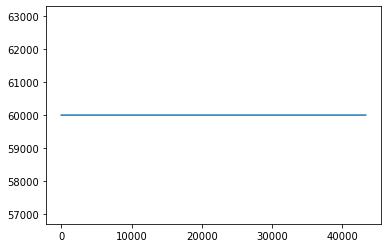

In [5]:
ret_df['strike'].plot()

### 1) Load quote data, finding the ATM option, produce the spread at minutes level

In [6]:
def get_spread_from_ATM_option_quote_data(date):
    """
    load quote data -> find the ATM call -> calcuate spread, resample at 1 min level -> return the max spread time series
    """
    df = data_loader(exchange='deribit', date = date.strftime('%Y-%m-%d'), data_type='quotes', symbol='OPTIONS', )
    df1 = df[['symbol','timestamp','ask_price','bid_price']]
    df2 = df1[df1['symbol'].str.contains('BTC') & df1['symbol'].str.contains('-C')]
    df2['spread'] = df2['ask_price'] - df2['bid_price']
    df3 = df2[['symbol','timestamp','spread']]
    ATM_call = df3.groupby('symbol')['spread'].count().sort_values(ascending=False).index[0]
    df4 = df3.query('symbol==@ATM_call')
    df4['dt'] = pd.to_datetime(df4['timestamp'], unit='us')
    df5 = df4.set_index('dt').resample('1T')['spread'].max()
    df5 = df5[df5.index>=date]
    return df5

In [7]:
from cdcqr.data.dataloader import data_loader
dates = pd.date_range(datetime(2021,1,1), datetime(2021,10,28))
date = dates[0]

In [3]:
get_spread_from_ATM_option_quote_data(date)

dt
2021-01-01 00:00:00    0.0460
2021-01-01 00:01:00    0.0400
2021-01-01 00:02:00    0.0410
2021-01-01 00:03:00    0.0405
2021-01-01 00:04:00    0.0395
                        ...  
2021-01-01 23:55:00    0.0345
2021-01-01 23:56:00    0.0375
2021-01-01 23:57:00    0.0380
2021-01-01 23:58:00    0.0380
2021-01-01 23:59:00    0.0385
Freq: T, Name: spread, Length: 1440, dtype: float64

### 2) run the above function in parallel

In [31]:
dates = pd.date_range(datetime(2021,1,1), datetime(2021,4,1))
dates2 = pd.date_range(datetime(2021,4,2), datetime(2021,7,1))
dates3 = pd.date_range(datetime(2021,7,2), datetime(2021,10,27))


In [32]:
ret_dict = parallel_jobs(get_spread_from_ATM_option_quote_data, dates3)

processing individual tasks 99.152542%

'parallel_jobs'  279.24 sec


In [33]:
ret_df = pd.concat(ret_dict.values()).sort_index()

In [34]:
ret_df_08_10= ret_df.copy()

In [27]:
ret_df_04_07 = ret_df.copy()

<AxesSubplot:xlabel='dt'>

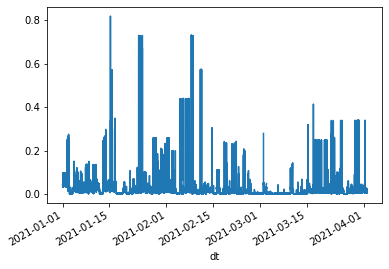

In [21]:
ret_df.plot()

In [22]:
ret_df_01_03 = ret_df.copy()

<AxesSubplot:xlabel='dt'>

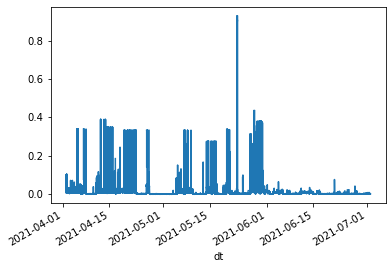

In [28]:
ret_df_04_07.plot()

<AxesSubplot:xlabel='dt'>

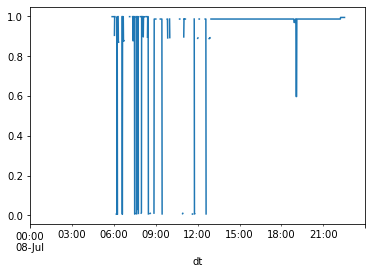

In [74]:
df_2021[(df_2021['dt']>=datetime(2021,7,8,0,0)) & (df_2021['dt']<datetime(2021,7,9,0,0))].set_index('dt')['spread'].plot()

<AxesSubplot:xlabel='dt'>

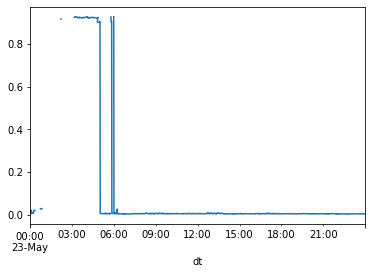

In [ ]:
df_2021[(df_2021['dt']>=datetime(2021,5,23,0,0)) & (df_2021['dt']<datetime(2021,5,24,0,0))].set_index('dt')['spread'].plot()

In [36]:
ret_df_04_07.shape

(129888,)

In [39]:
ret_df_08_10.shape

(166366,)

In [41]:
df_2021 = ret_df_01_03.append(ret_df_04_07).append(ret_df_08_10)

In [62]:
df_2021['date'] = df_2021['dt'].dt.date

In [63]:
df_2021.to_pickle()

,dt,spread,date
0,2021-01-01 00:00:00,0.0460,2021-01-01
1,2021-01-01 00:01:00,0.0400,2021-01-01
2,2021-01-01 00:02:00,0.0410,2021-01-01
3,2021-01-01 00:03:00,0.0405,2021-01-01
4,2021-01-01 00:04:00,0.0395,2021-01-01
...,...,...,...
427280,2021-10-27 23:55:00,0.0015,2021-10-27
427281,2021-10-27 23:56:00,0.0015,2021-10-27
427282,2021-10-27 23:57:00,0.0015,2021-10-27
427283,2021-10-27 23:58:00,0.0015,2021-10-27


### 3) find the spike periods

<AxesSubplot:xlabel='dt'>

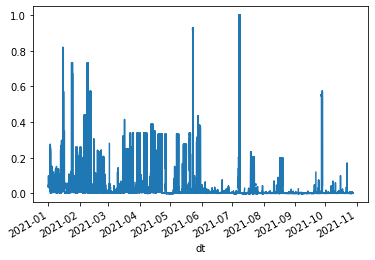

In [43]:
df_2021.plot()

In [60]:
df_2021 = df_2021.reset_index()

#### spikes >=0.5

In [49]:
spikes_lv1 = df_2021[df_2021>=0.5].reset_index()

In [51]:
spikes_lv1['date'] = spikes_lv1['dt'].dt.date

In [53]:
spikes_lv1.groupby('date').count()

,dt,spread
date,,
2021-01-15,5,5
2021-01-23,4,4
2021-01-24,4,4
2021-02-08,34,34
2021-02-11,72,72
2021-05-23,110,110
2021-07-08,701,701
2021-09-27,132,132


dt
2021-09-27    0.011
Name: spread, dtype: float64

<AxesSubplot:xlabel='dt'>

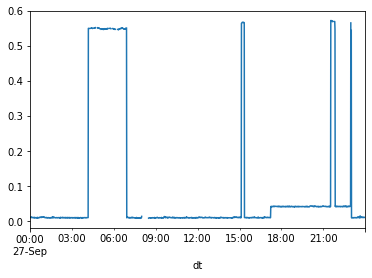

In [73]:
df_2021[(df_2021['dt']>=datetime(2021,9,27,0,0)) & (df_2021['dt']<datetime(2021,9,28,0,0))].set_index('dt')['spread'].plot()

### on 20210519, check ATM bid/ask price, quantity and flow for 40k, 32k, 48k put/call with expire on 20211231 

In [10]:
ret_dict, ret_df_40C = quoto_and_trade_analysis(contract='BTC-31DEC21-40000-C', date='2021-05-19')

processing data BTC-31DEC21-40000-C 2021-05-19 deribit
'parse_optSymbol_col'  27.17 sec
'parse_time_col'  3.74 sec


In [11]:
ret_dict, ret_df_40P = quoto_and_trade_analysis(contract='BTC-31DEC21-40000-P', date='2021-05-19')

processing data BTC-31DEC21-40000-P 2021-05-19 deribit
'parse_optSymbol_col'  27.29 sec
'parse_time_col'  3.74 sec


In [12]:
ret_dict, ret_df_32P = quoto_and_trade_analysis(contract='BTC-31DEC21-32000-P', date='2021-05-19')

processing data BTC-31DEC21-32000-P 2021-05-19 deribit
'parse_optSymbol_col'  27.53 sec
'parse_time_col'  3.78 sec


In [13]:
ret_dict, ret_df_32C = quoto_and_trade_analysis(contract='BTC-31DEC21-32000-C', date='2021-05-19')

processing data BTC-31DEC21-32000-C 2021-05-19 deribit
'parse_optSymbol_col'  27.55 sec
'parse_time_col'  3.74 sec


In [14]:
ret_dict, ret_df_48C = quoto_and_trade_analysis(contract='BTC-31DEC21-48000-C', date='2021-05-19')

processing data BTC-31DEC21-48000-C 2021-05-19 deribit
'parse_optSymbol_col'  27.29 sec
'parse_time_col'  3.79 sec


In [15]:
ret_dict, ret_df_48P = quoto_and_trade_analysis(contract='BTC-31DEC21-48000-P', date='2021-05-19')

processing data BTC-31DEC21-48000-P 2021-05-19 deribit
'parse_optSymbol_col'  27.31 sec
'parse_time_col'  3.75 sec


### 40K CALL

In [25]:
df2plot = ret_df_40C.query('timestamp_dt>=datetime(2021,5,19,16,25)').query('timestamp_dt<=datetime(2021,5,19,16,40)').set_index('timestamp_dt')[['ask_price','bid_price','flow']]
fig, ax1 = plt.subplots(1,1, figsize=(8*4,6))
df2plot[['ask_price','bid_price',]].plot(ax=ax1, linestyle='None', marker = '.')
ax2 = ax1.twinx()
df2plot['flow'] = df2plot['flow'].replace(0, np.nan)
df2plot['flow'].plot(ax=ax2, legend=['trade'], color = ['b'], linestyle='None', marker = 'x')
plt.title('BTC-31DEC21-40000-C')
plt.show()

In [46]:
ret_df_40C.head(2)

,exchange,symbol,timestamp,local_timestamp,ask_amount,ask_price,bid_price,bid_amount,instrument,expire,...,timestamp_dt,t2m,flow,has_trade,trade_neighbour,mid_price,wgt_mid_price,midp_chg,wgtmidp_chg,spread
0,deribit,BTC-31DEC21-40000-C,1621382400140000,1621382400475156,11.0,0.397,0.3505,11.0,BTC,2021-12-31 08:00:00,...,2021-05-19 00:00:00.140,5432.0,0.0,NaN,False,0.37375,0.373750,NaN,NaN,0.0465
1,deribit,BTC-31DEC21-40000-C,1621382482200000,1621382482229755,11.0,0.397,0.3500,51.0,BTC,2021-12-31 08:00:00,...,2021-05-19 00:01:22.200,5432.0,0.0,NaN,False,0.37350,0.358339,-0.000669,-0.041234,0.0470


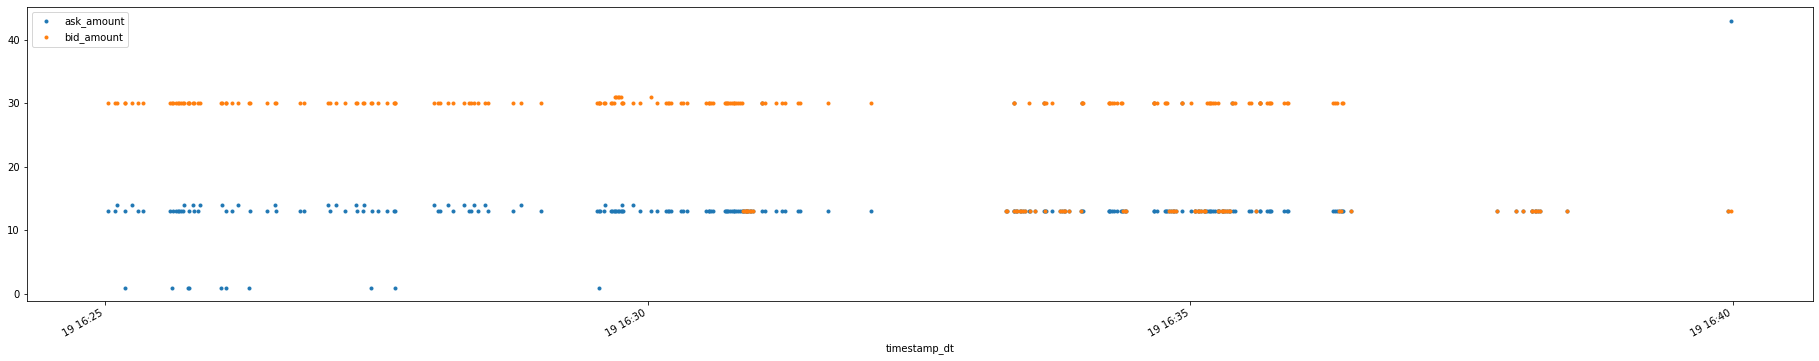

In [61]:
df2plot = ret_df_40C.query('timestamp_dt>=datetime(2021,5,19,16,25)').query('timestamp_dt<=datetime(2021,5,19,16,40)').set_index('timestamp_dt')[['ask_amount','bid_amount','flow']]
fig, ax1 = plt.subplots(1,1, figsize=(8*4,6))
df2plot[['ask_amount','bid_amount',]].plot(ax=ax1, linestyle='None', marker = '.')
plt.show()

### 40K PUT

In [26]:
df2plot = ret_df_40P.query('timestamp_dt>=datetime(2021,5,19,16,25)').query('timestamp_dt<=datetime(2021,5,19,16,40)').set_index('timestamp_dt')[['ask_price','bid_price','flow']]
fig, ax1 = plt.subplots(1,1, figsize=(8*4,6))
df2plot[['ask_price','bid_price',]].plot(ax=ax1, linestyle='None', marker = '.')
ax2 = ax1.twinx()
df2plot['flow'] = df2plot['flow'].replace(0, np.nan)
df2plot['flow'].plot(ax=ax2, legend=['trade'], color = ['b'], linestyle='None', marker = 'x')
plt.title('BTC-31DEC21-40000-P')
plt.show()

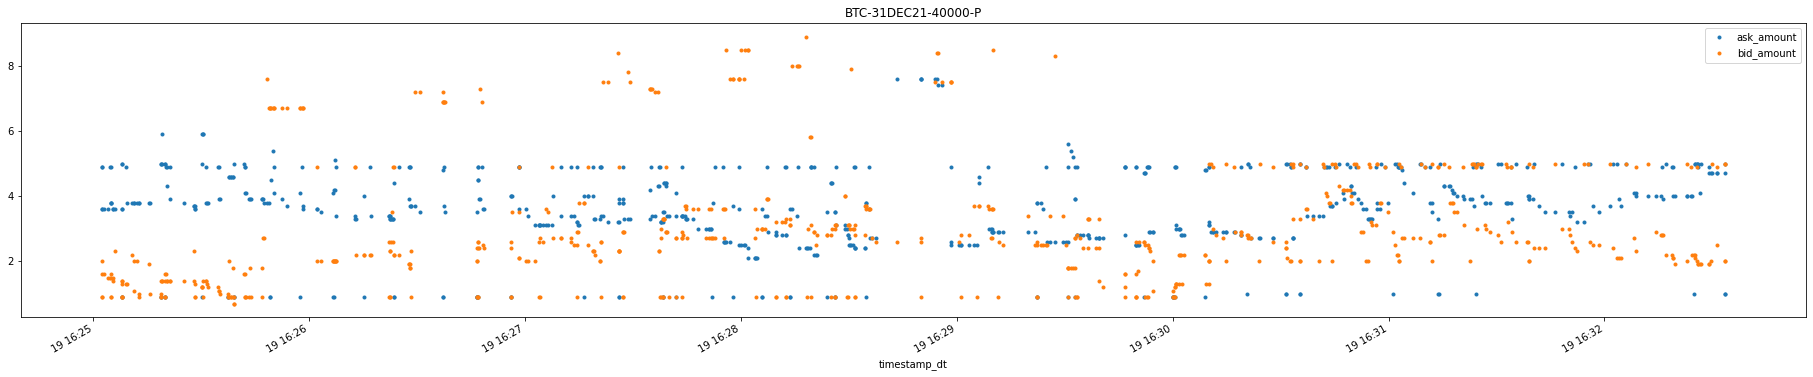

In [60]:
df2plot = ret_df_40P.query('timestamp_dt>=datetime(2021,5,19,16,25)').query('timestamp_dt<=datetime(2021,5,19,16,40)').set_index('timestamp_dt')[['ask_amount','bid_amount','flow']]
fig, ax1 = plt.subplots(1,1, figsize=(8*4,6))
df2plot[['ask_amount','bid_amount',]].plot(ax=ax1, linestyle='None', marker = '.')
plt.title('BTC-31DEC21-40000-P')
plt.show()

#### 32K CALL

In [27]:
df2plot = ret_df_32C.query('timestamp_dt>=datetime(2021,5,19,16,25)').query('timestamp_dt<=datetime(2021,5,19,16,40)').set_index('timestamp_dt')[['ask_price','bid_price','flow']]
fig, ax1 = plt.subplots(1,1, figsize=(8*4,6))
df2plot[['ask_price','bid_price',]].plot(ax=ax1, linestyle='None', marker = '.')
ax2 = ax1.twinx()
df2plot['flow'] = df2plot['flow'].replace(0, np.nan)
df2plot['flow'].plot(ax=ax2, legend=['trade'], color = ['b'], linestyle='None', marker = 'x')
plt.title('BTC-31DEC21-32000-C')
plt.show()

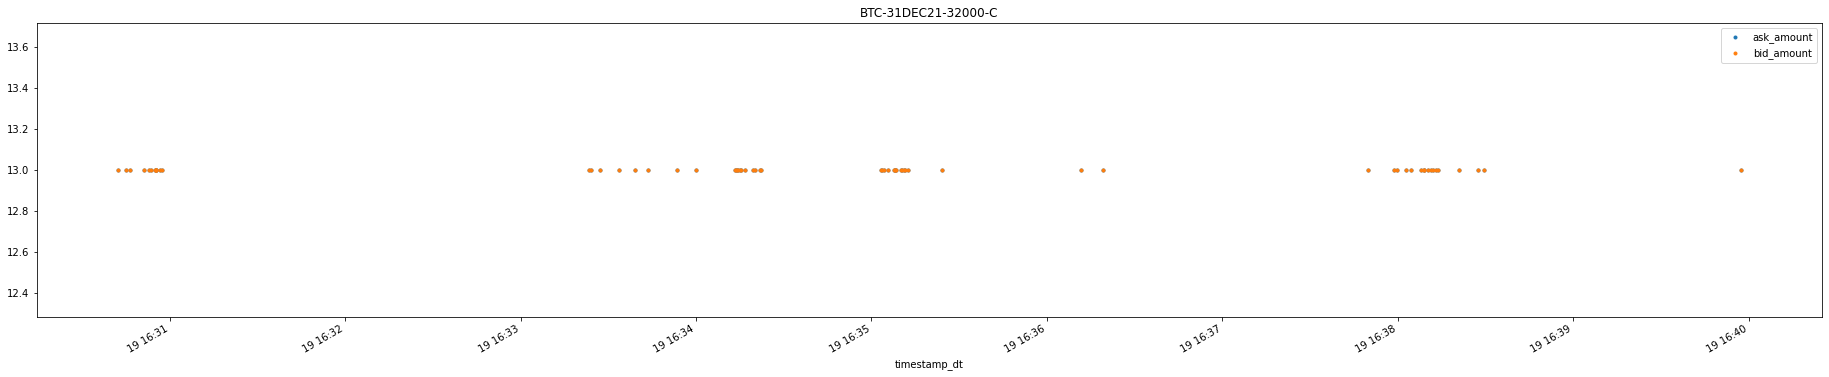

In [62]:
df2plot = ret_df_32C.query('timestamp_dt>=datetime(2021,5,19,16,25)').query('timestamp_dt<=datetime(2021,5,19,16,40)').set_index('timestamp_dt')[['ask_amount','bid_amount','flow']]
fig, ax1 = plt.subplots(1,1, figsize=(8*4,6))
df2plot[['ask_amount','bid_amount',]].plot(ax=ax1, linestyle='None', marker = '.')
plt.title('BTC-31DEC21-32000-C')
plt.show()

#### 32K PUT

In [33]:
df2plot = ret_df_32P.query('timestamp_dt>=datetime(2021,5,19,16,25)').query('timestamp_dt<=datetime(2021,5,19,16,40)').set_index('timestamp_dt')[['ask_price','bid_price','flow']]
fig, ax1 = plt.subplots(1,1, figsize=(8*4,6))
df2plot[['ask_price','bid_price',]].plot(ax=ax1, linestyle='None', marker = '.')
ax2 = ax1.twinx()
df2plot['flow'] = df2plot['flow'].replace(0, np.nan)
df2plot['flow'].plot(ax=ax2, legend=['trade'], color = ['b'], linestyle='None', marker = 'x')
plt.title('BTC-31DEC21-32000-P')
plt.show()

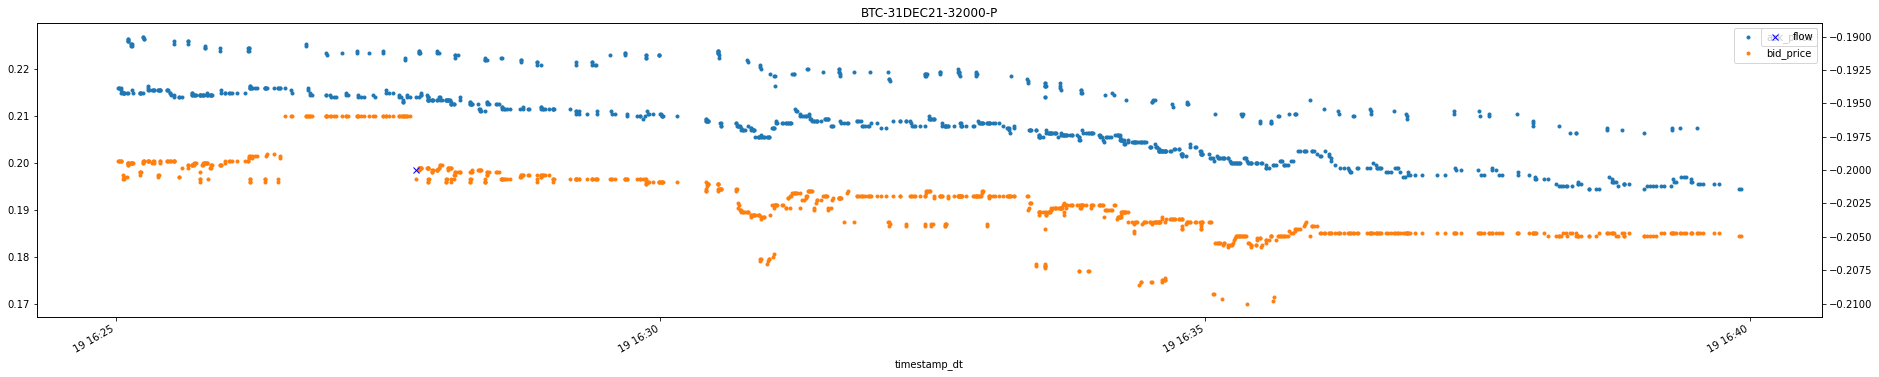

In [33]:
df2plot = ret_df_32P.query('timestamp_dt>=datetime(2021,5,19,16,25)').query('timestamp_dt<=datetime(2021,5,19,16,40)').set_index('timestamp_dt')[['ask_amount','bid_amount','flow']]
fig, ax1 = plt.subplots(1,1, figsize=(8*4,6))
df2plot[['ask_amount','bid_amount',]].plot(ax=ax1, linestyle='None', marker = '.')
plt.title('BTC-31DEC21-32000-P')
plt.show()

#### 48K CALL

In [45]:
df2plot = ret_df_48C.query('timestamp_dt>=datetime(2021,5,19,16,25)').query('timestamp_dt<=datetime(2021,5,19,16,40)').set_index('timestamp_dt')[['ask_price','bid_price','flow']]
#df2plot = ret_df_48P.set_index('timestamp_dt')[['ask_price','bid_price','flow']]
fig, ax1 = plt.subplots(1,1, figsize=(8*4,6))
df2plot[['ask_price','bid_price',]].plot(ax=ax1, linestyle='None', marker = '.')
ax2 = ax1.twinx()
df2plot['flow'].plot(ax=ax2, legend=['trade'], color = ['b'], linestyle='None', marker = 'x')
plt.title('BTC-31DEC21-48000-P')
plt.show()

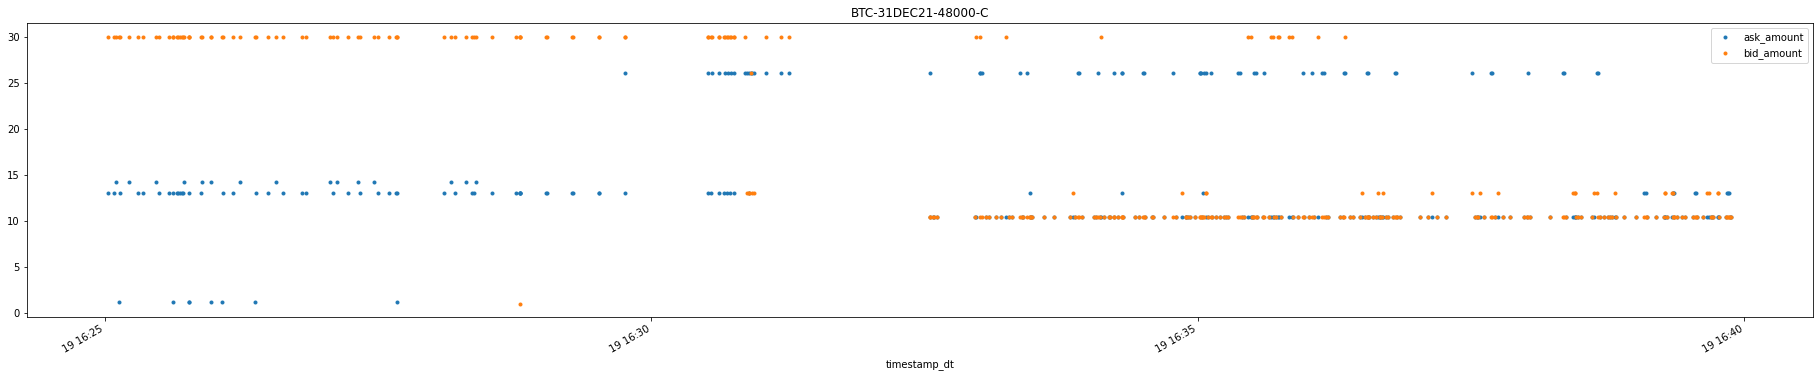

In [63]:
df2plot = ret_df_48C.query('timestamp_dt>=datetime(2021,5,19,16,25)').query('timestamp_dt<=datetime(2021,5,19,16,40)').set_index('timestamp_dt')[['ask_amount','bid_amount','flow']]
fig, ax1 = plt.subplots(1,1, figsize=(8*4,6))
df2plot[['ask_amount','bid_amount',]].plot(ax=ax1, linestyle='None', marker = '.')
plt.title('BTC-31DEC21-48000-C')
plt.show()

#### 48K PUT

In [30]:
df2plot = ret_df_48P.query('timestamp_dt>=datetime(2021,5,19,16,25)').query('timestamp_dt<=datetime(2021,5,19,16,40)').set_index('timestamp_dt')[['ask_price','bid_price','flow']]
fig, ax1 = plt.subplots(1,1, figsize=(8*4,6))
df2plot[['ask_price','bid_price',]].plot(ax=ax1, linestyle='None', marker = '.')
ax2 = ax1.twinx()
df2plot['flow'].plot(ax=ax2, legend=['trade'], color = ['b'], linestyle='None', marker = 'x')
plt.title('BTC-31DEC21-48000-P')
plt.show()

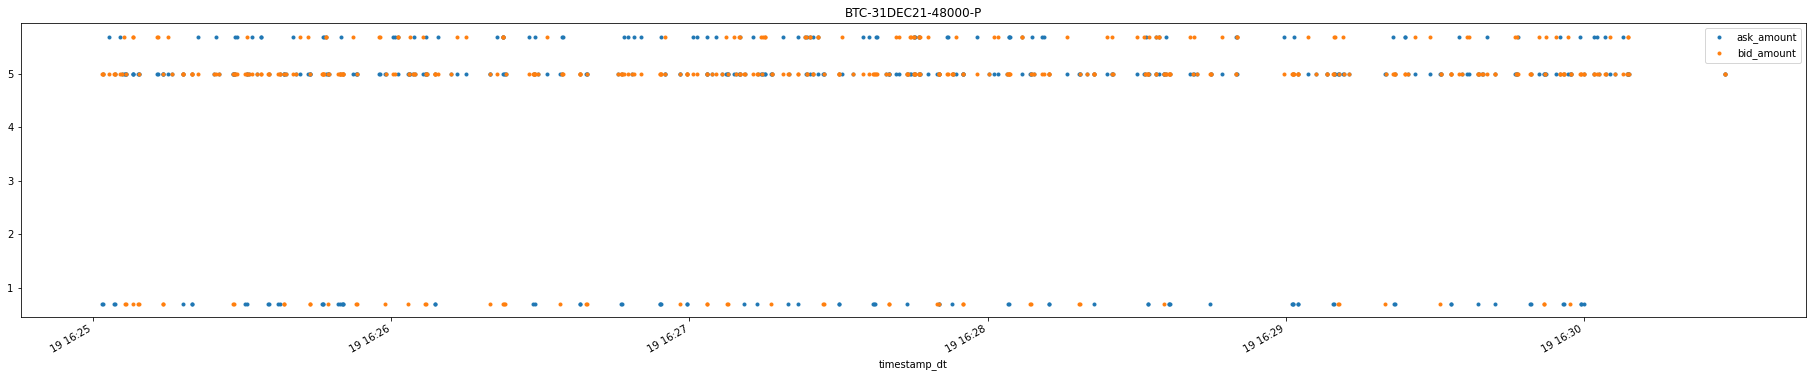

In [64]:
df2plot = ret_df_48P.query('timestamp_dt>=datetime(2021,5,19,16,25)').query('timestamp_dt<=datetime(2021,5,19,16,40)').set_index('timestamp_dt')[['ask_amount','bid_amount','flow']]
fig, ax1 = plt.subplots(1,1, figsize=(8*4,6))
df2plot[['ask_amount','bid_amount',]].plot(ax=ax1, linestyle='None', marker = '.')
plt.title('BTC-31DEC21-48000-P')
plt.show()

#### PERP

#### OERDERBOOK

In [103]:
[x for x in list(df['symbol'].unique()) if 'BTC-31DEC21' in x]

['BTC-31DEC21-64000-C',
 'BTC-31DEC21-50000-P',
 'BTC-31DEC21-400000-C',
 'BTC-31DEC21-32000-P',
 'BTC-31DEC21-32000-C',
 'BTC-31DEC21-28000-P',
 'BTC-31DEC21-26000-P',
 'BTC-31DEC21-26000-C',
 'BTC-31DEC21-24000-P',
 'BTC-31DEC21-22000-C',
 'BTC-31DEC21-200000-P',
 'BTC-31DEC21-20000-C',
 'BTC-31DEC21-160000-P',
 'BTC-31DEC21-160000-C',
 'BTC-31DEC21-140000-P',
 'BTC-31DEC21-140000-C',
 'BTC-31DEC21-120000-P',
 'BTC-31DEC21-100000-P',
 'BTC-31DEC21-100000-C',
 'BTC-31DEC21-50000-C',
 'BTC-31DEC21-48000-P',
 'BTC-31DEC21-48000-C',
 'BTC-31DEC21-400000-P',
 'BTC-31DEC21-300000-P',
 'BTC-31DEC21-300000-C',
 'BTC-31DEC21-22000-P',
 'BTC-31DEC21-200000-C',
 'BTC-31DEC21-20000-P',
 'BTC-31DEC21-18000-C',
 'BTC-31DEC21-16000-P',
 'BTC-31DEC21-120000-C',
 'BTC-31DEC21-80000-P',
 'BTC-31DEC21-80000-C',
 'BTC-31DEC21-64000-P',
 'BTC-31DEC21-60000-P',
 'BTC-31DEC21-60000-C',
 'BTC-31DEC21-40000-P',
 'BTC-31DEC21-40000-C',
 'BTC-31DEC21-28000-C',
 'BTC-31DEC21-24000-C',
 'BTC-31DEC21-18000-P',
 '

In [ ]:
quoto_and_trade_analysis??

In [179]:
exchange = 'deribit'
date = '2021-05-19'
symbol = 'OPTIONS'
df_opt_trade = data_loader(exchange, date,"trades",symbol)

In [180]:
df_opt_trade = df_opt_trade.query('symbol=="BTC-31DEC21-40000-P"')

In [181]:
df_opt_trade['dt'] = pd.to_datetime(df_opt_trade['timestamp'], unit='us') # check convert ts

In [182]:
pd.set_option('display.max_rows', 500)

In [ ]:
df_opt_trade.set_index('dt')

In [177]:
ret_df_48P.query('timestamp_dt>=datetime(2021,5,19,15,00)').query('timestamp_dt<=datetime(2021,5,19,16,00)')

,exchange,symbol,timestamp,local_timestamp,ask_amount,ask_price,bid_price,bid_amount,instrument,expire,...,timestamp_dt,t2m,flow,has_trade,trade_neighbour,mid_price,wgt_mid_price,midp_chg,wgtmidp_chg,spread
16704,deribit,BTC-31DEC21-48000-P,1621437721972000,1621437722447739,1.0,1.0000,0.3600,14.0,BTC,2021-12-31 08:00:00,...,2021-05-19 15:22:01.972,5417.0,0.0,NaN,False,0.68000,0.402667,0.007407,-0.572045,0.6400
16705,deribit,BTC-31DEC21-48000-P,1621437747673000,1621437747690203,1.0,1.0000,0.3500,0.1,BTC,2021-12-31 08:00:00,...,2021-05-19 15:22:27.673,5417.0,0.0,NaN,False,0.67500,0.940909,-0.007353,1.336695,0.6500
16706,deribit,BTC-31DEC21-48000-P,1621438253125000,1621438253260786,1.0,1.0000,0.4665,0.7,BTC,2021-12-31 08:00:00,...,2021-05-19 15:30:53.125,5417.0,0.0,NaN,False,0.73325,0.780324,0.086296,-0.170671,0.5335
16707,deribit,BTC-31DEC21-48000-P,1621438253130000,1621438253260790,0.7,0.5205,0.4665,0.7,BTC,2021-12-31 08:00:00,...,2021-05-19 15:30:53.130,5417.0,0.0,NaN,False,0.49350,0.493500,-0.326969,-0.367570,0.0540
16708,deribit,BTC-31DEC21-48000-P,1621438253483000,1621438253707287,0.7,0.5205,0.4670,0.7,BTC,2021-12-31 08:00:00,...,2021-05-19 15:30:53.483,5417.0,0.0,NaN,False,0.49375,0.493750,0.000507,0.000507,0.0535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17919,deribit,BTC-31DEC21-48000-P,1621439440702000,1621439440713160,0.7,0.4970,0.4545,4.2,BTC,2021-12-31 08:00:00,...,2021-05-19 15:50:40.702,5417.0,0.0,NaN,False,0.47575,0.460571,-0.000525,-0.038990,0.0425
17920,deribit,BTC-31DEC21-48000-P,1621439440813000,1621439440842870,0.7,0.4970,0.4535,4.2,BTC,2021-12-31 08:00:00,...,2021-05-19 15:50:40.813,5417.0,0.0,NaN,False,0.47525,0.459714,-0.001051,-0.001861,0.0435
17921,deribit,BTC-31DEC21-48000-P,1621439440814000,1621439440963097,5.0,0.4965,0.4535,4.2,BTC,2021-12-31 08:00:00,...,2021-05-19 15:50:40.814,5417.0,0.0,NaN,False,0.47500,0.476870,-0.000526,0.037317,0.0430
17922,deribit,BTC-31DEC21-48000-P,1621439449887000,1621439450422864,5.0,0.9995,0.3500,0.1,BTC,2021-12-31 08:00:00,...,2021-05-19 15:50:49.887,5417.0,0.0,NaN,False,0.67475,0.986765,0.420526,1.069255,0.6495


In [205]:
ret_df_40P.query('timestamp_dt>=datetime(2021,5,19,15,)').query('timestamp_dt<=datetime(2021,5,19,16,)')

,exchange,symbol,timestamp,local_timestamp,ask_amount,ask_price,bid_price,bid_amount,instrument,expire,...,timestamp_dt,t2m,flow,has_trade,trade_neighbour,mid_price,wgt_mid_price,midp_chg,wgtmidp_chg,spread
29117,deribit,BTC-31DEC21-40000-P,1621436411041000,1621436411588099,7.0,0.3765,0.340,0.1,BTC,2021-12-31 08:00:00,...,2021-05-19 15:00:11.041,5417.0,0.0,NaN,False,0.35825,0.375986,0.030935,0.060133,0.0365
29118,deribit,BTC-31DEC21-40000-P,1621436412235000,1621436413079917,4.3,0.3600,0.340,0.1,BTC,2021-12-31 08:00:00,...,2021-05-19 15:00:12.235,5417.0,0.0,NaN,False,0.35000,0.359545,-0.023029,-0.043726,0.0200
29119,deribit,BTC-31DEC21-40000-P,1621436414684000,1621436415167651,7.0,0.3765,0.340,0.1,BTC,2021-12-31 08:00:00,...,2021-05-19 15:00:14.684,5417.0,0.0,NaN,False,0.35825,0.375986,0.023571,0.045726,0.0365
29120,deribit,BTC-31DEC21-40000-P,1621436416298000,1621436416741610,4.3,0.3620,0.340,0.1,BTC,2021-12-31 08:00:00,...,2021-05-19 15:00:16.298,5417.0,0.0,NaN,False,0.35100,0.361500,-0.020237,-0.038528,0.0220
29121,deribit,BTC-31DEC21-40000-P,1621436419085000,1621436419794221,4.3,0.3600,0.340,0.1,BTC,2021-12-31 08:00:00,...,2021-05-19 15:00:19.085,5417.0,0.0,NaN,False,0.35000,0.359545,-0.002849,-0.005407,0.0200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32370,deribit,BTC-31DEC21-40000-P,1621439996307000,1621439996384069,4.9,0.3500,0.324,2.9,BTC,2021-12-31 08:00:00,...,2021-05-19 15:59:56.307,5417.0,0.0,NaN,False,0.33700,0.340333,0.000742,0.011437,0.0260
32371,deribit,BTC-31DEC21-40000-P,1621439997219000,1621439997481762,4.7,0.3490,0.324,2.8,BTC,2021-12-31 08:00:00,...,2021-05-19 15:59:57.219,5417.0,0.0,NaN,False,0.33650,0.339667,-0.001484,-0.001959,0.0250
32372,deribit,BTC-31DEC21-40000-P,1621439997795000,1621439998705539,5.1,0.3485,0.324,2.5,BTC,2021-12-31 08:00:00,...,2021-05-19 15:59:57.795,5417.0,0.0,NaN,False,0.33625,0.340441,-0.000743,0.002279,0.0245
32373,deribit,BTC-31DEC21-40000-P,1621439998313000,1621439998771237,4.5,0.3480,0.324,2.5,BTC,2021-12-31 08:00:00,...,2021-05-19 15:59:58.313,5417.0,0.0,NaN,False,0.33600,0.339429,-0.000743,-0.002973,0.0240


### check order book snapshot

In [ ]:
exchange = 'deribit'
date = '2021-05-19'
symbol = 'OPTIONS'
data_type = 'book_snapshot_25'
df_snapshot = data_loader(exchange, date,data_type,symbol)

In [ ]:
df_snapshot.head()

In [134]:
optchain1Min_20210519_20211231 = pd.read_pickle(os.path.join(LOCAL_DATA_DIR, 'optchain1Min_20210519_20211231.pkl'))

In [135]:
optchain1Min_20210519_20211231['underly'].unique()

array(['ETH-31DEC21', 'BTC-31DEC21'], dtype=object)

<AxesSubplot:xlabel='tm'>

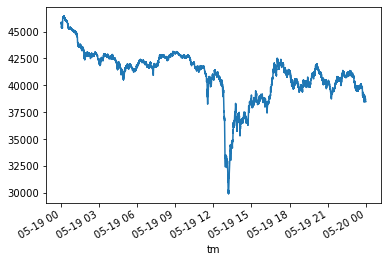

In [136]:
optchain1Min_20210519_20211231.query('underly=="BTC-31DEC21"')['s'].plot()

<AxesSubplot:title={'center':'32k'}, xlabel='tm'>

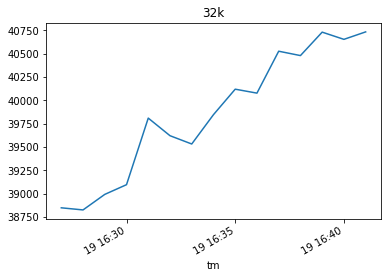

In [137]:
optchain1Min_20210519_20211231.query('underly=="BTC-31DEC21"').query('symbol=="BTC-31DEC21-32000-C"').query('tm>=datetime(2021,5,19,16,25)').query('tm<=datetime(2021,5,19,16,40)')['s'].plot(title='32k')

<AxesSubplot:title={'center':'40k'}, xlabel='tm'>

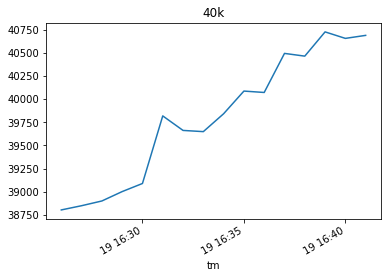

In [138]:
optchain1Min_20210519_20211231.query('underly=="BTC-31DEC21"').query('symbol=="BTC-31DEC21-40000-C"').query('tm>=datetime(2021,5,19,16,25)').query('tm<=datetime(2021,5,19,16,40)')['s'].plot(title='40k')

<AxesSubplot:title={'center':'48k'}, xlabel='tm'>

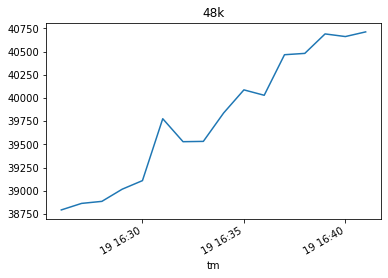

In [139]:
optchain1Min_20210519_20211231.query('underly=="BTC-31DEC21"').query('symbol=="BTC-31DEC21-48000-C"').query('tm>=datetime(2021,5,19,16,25)').query('tm<=datetime(2021,5,19,16,40)')['s'].plot(title='48k')

### time graph for all strikes near ATM of (bid+ask) amount , and on axis2  spot price and underlying futures price

In [140]:
## data 1: optchain
optchain1Min_20210519_20211231 = pd.read_pickle(os.path.join(LOCAL_DATA_DIR, 'optchain1Min_20210519_20211231.pkl'))

In [ ]:
# data 2: quote and trade
ret_df_40C.head()

In [110]:
# data 3: PERP
exchange = 'deribit'
date = '2021-05-19'
symbol = 'BTC-PERPETUAL'
data_type = 'quotes'
df_perp = data_loader(exchange, date,data_type,symbol)

In [119]:
df_perp['dt'] = pd.to_datetime(df_perp['timestamp'], unit='us')
df_perp['mid'] = (df_perp['ask_price']+df_perp['bid_price'])/2
df_perp = df_perp.set_index('dt')
df_perp_1min = df_perp.resample('1min').mean()['mid']

In [132]:
ret_df_40C_ext = ret_df_40C.set_index('timestamp_dt').reindex(optchina_btc_c.index, method='ffill').join(optchina_btc_c, lsuffix='_left', rsuffix='_right')

ret_df_40C_ext2 = ret_df_40C_ext.join(df_perp_1min)

df2plot = ret_df_40C_ext2[['total_amount','s','mid']]
fig, ax1 = plt.subplots(1,1, figsize=(8*4,6))

df2plot[['total_amount']].plot(ax=ax1,  linestyle='None', marker = '.', color=['r'])
ax1.legend(loc="upper left")
ax2 = ax1.twinx()
df2plot[['s','mid']].plot(ax=ax2,)
ax2.legend(['underlying','PERP'], loc="upper right")
plt.title('20210519 BTC 40K call expire=20211231 v.s. PERP and underlying')
plt.show()

In [ ]:
ret_df_40C['total_amount'] = ret_df_40C['ask_amount'] + ret_df_40C['bid_amount']

<AxesSubplot:xlabel='timestamp_dt'>

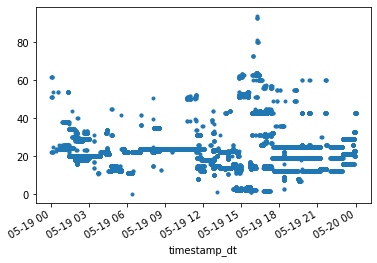

In [ ]:
ret_df_40C.set_index('timestamp_dt')['total_amount'].plot(linestyle='None', marker = '.')

32C BTC-31DEC21-32000-C


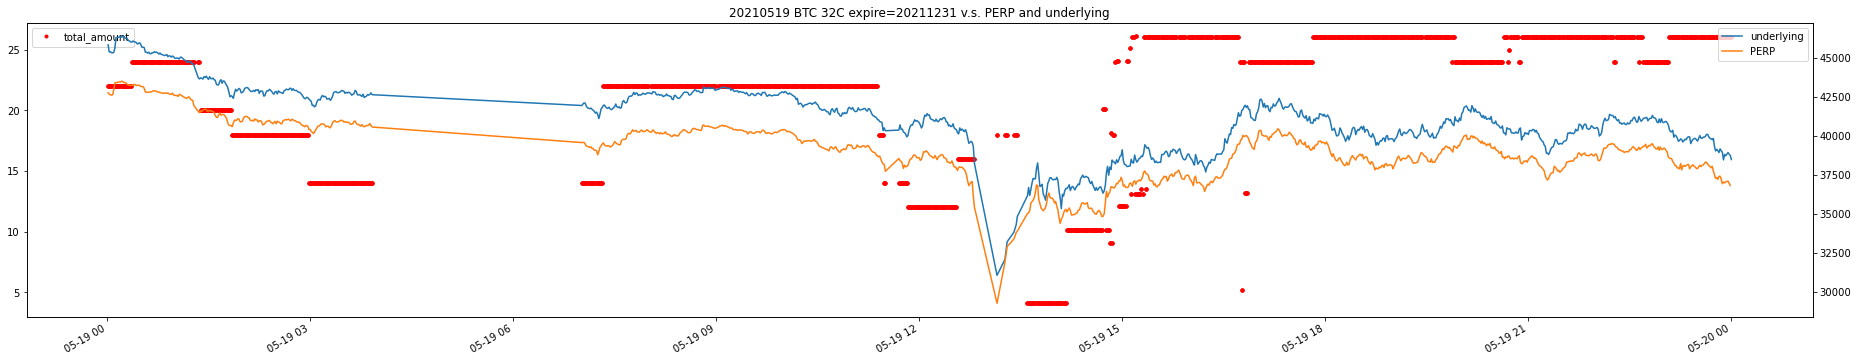

32P BTC-31DEC21-32000-P


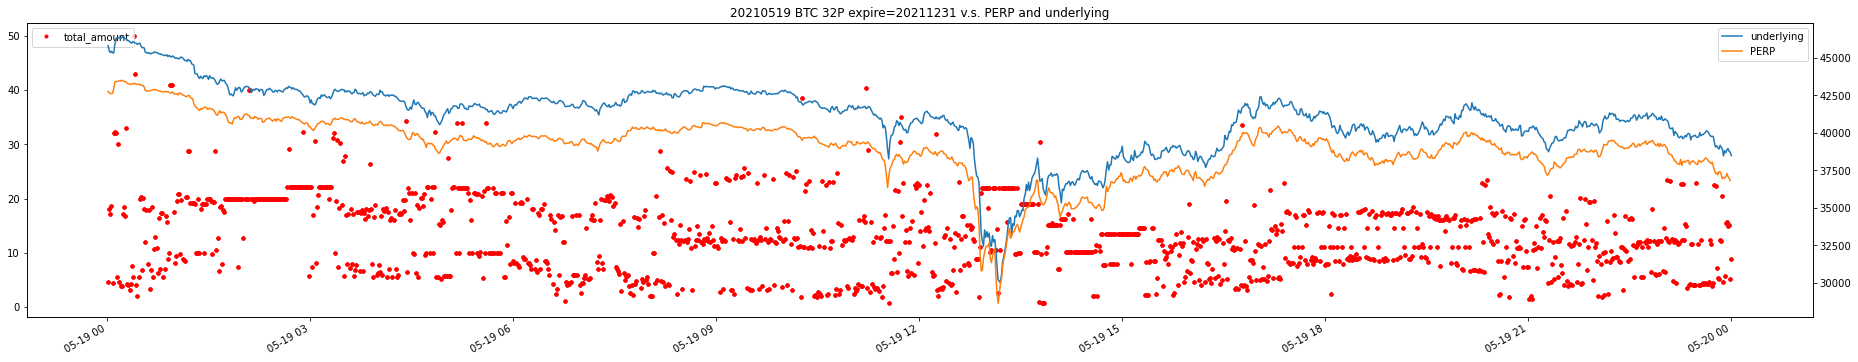

40C BTC-31DEC21-40000-C


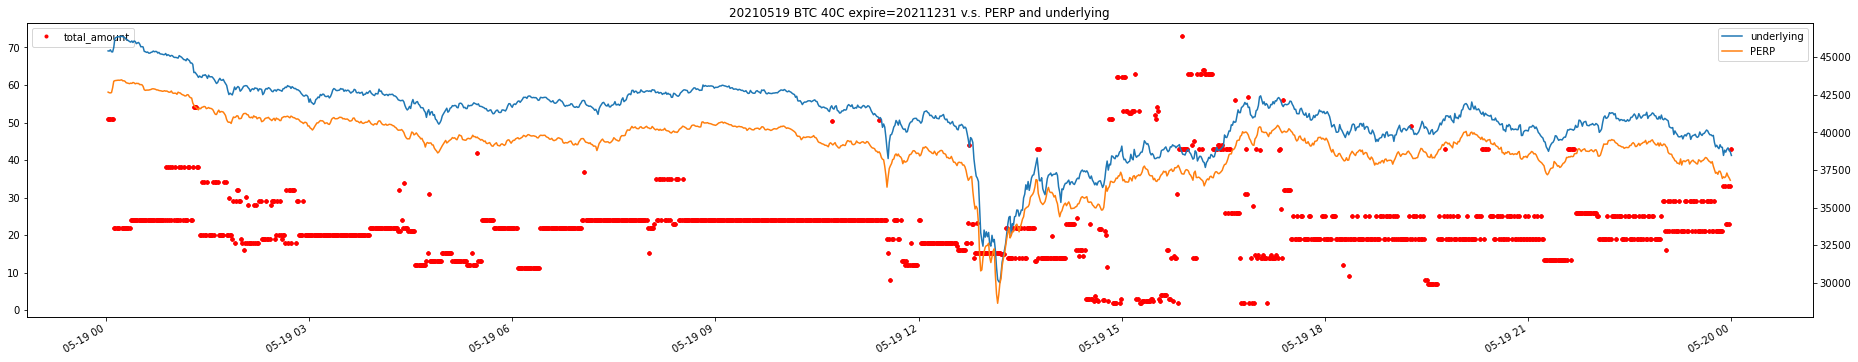

40P BTC-31DEC21-40000-P


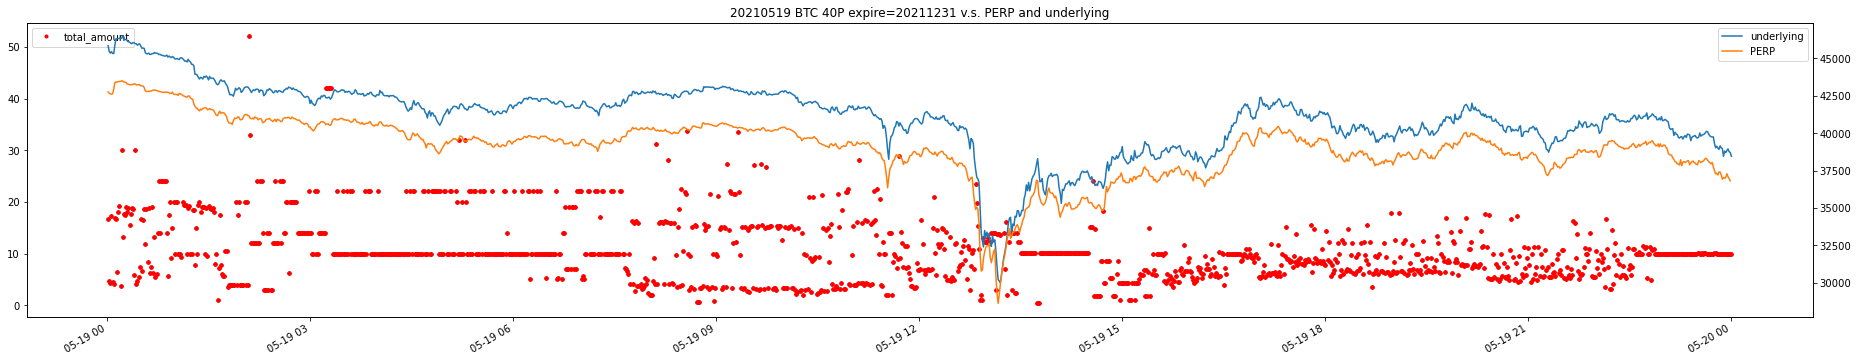

48C BTC-31DEC21-48000-C


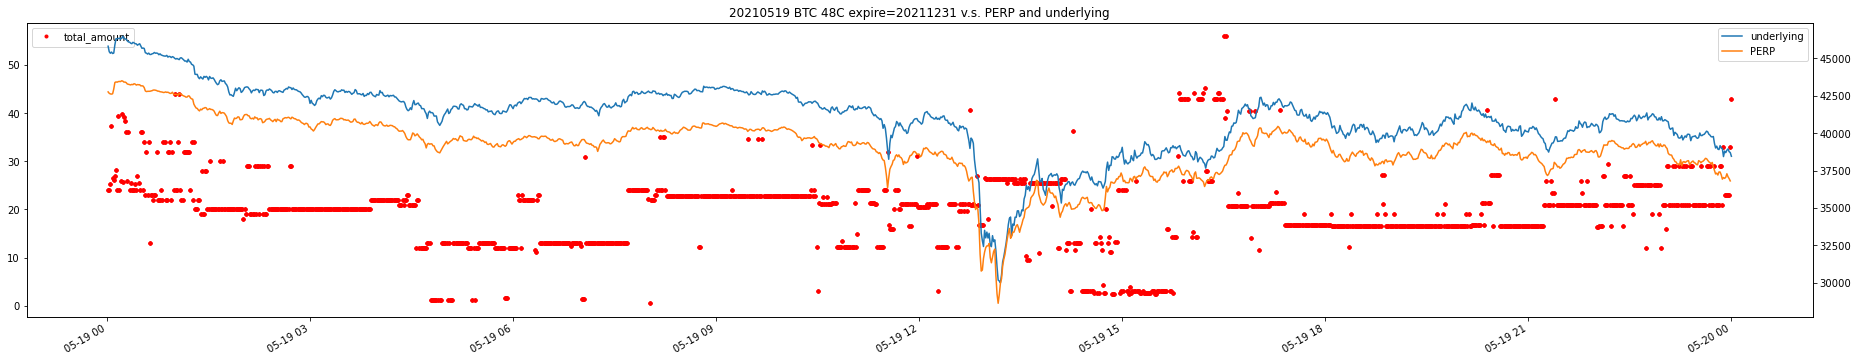

48P BTC-31DEC21-48000-P


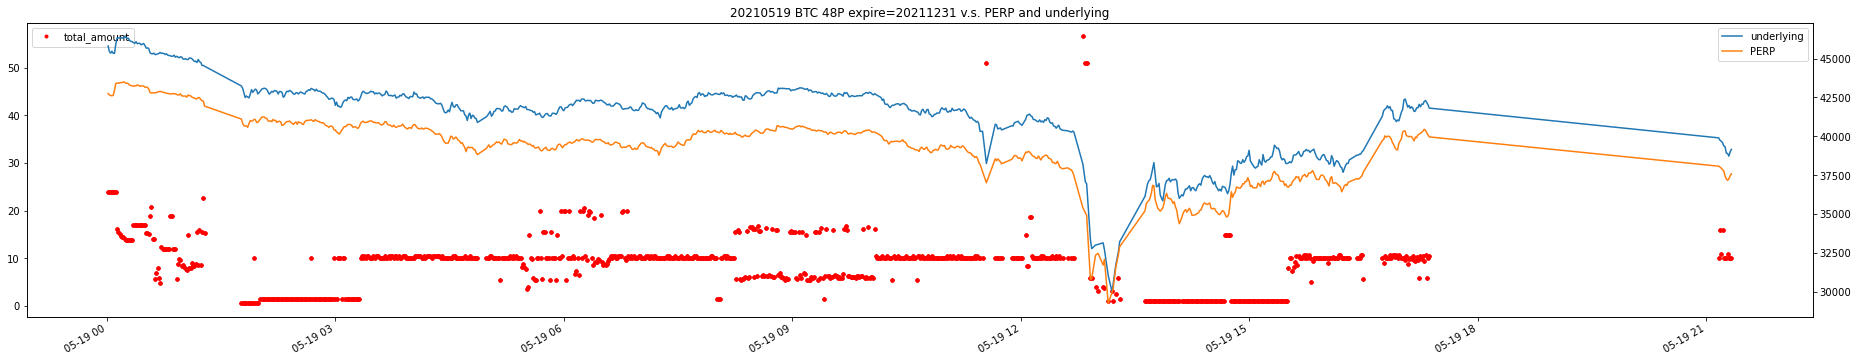

In [147]:
for df_quote_str, symbol in zip(['32C','32P','40C','40P','48C','48P'],['BTC-31DEC21-32000-C', 'BTC-31DEC21-32000-P', 'BTC-31DEC21-40000-C', 'BTC-31DEC21-40000-P', 'BTC-31DEC21-48000-C', 'BTC-31DEC21-48000-P']):
    print(df_quote_str, symbol)
    df_quote = eval('ret_df_{}'.format(df_quote_str))
    df_quote['total_amount'] = df_quote['ask_amount']+df_quote['bid_amount']
    optchain = optchain1Min_20210519_20211231.query('underly=="BTC-31DEC21"').query('symbol==@symbol')
    
    df_quote_ext = df_quote.set_index('timestamp_dt').reindex(optchain.index, method='ffill').join(optchain, lsuffix='_left', rsuffix='_right')

    df_quote_ext2 = df_quote_ext.join(df_perp_1min)

    df2plot = df_quote_ext2[['total_amount','s','mid']]
    fig, ax1 = plt.subplots(1,1, figsize=(8*4,6))

    df2plot[['total_amount']].plot(ax=ax1,  linestyle='None', marker = '.', color=['r'])
    ax1.legend(loc="upper left")
    ax2 = ax1.twinx()
    df2plot[['s','mid']].plot(ax=ax2,)
    ax2.legend(['underlying','PERP'], loc="upper right")
    plt.title('20210519 BTC {} expire=20211231 v.s. PERP and underlying'.format(df_quote_str))
    plt.show()
    

### put above plots into a single plot
   * using different marker size to represent amount of bid/ask
   * using diffrernt color to mark bid and ask 
   * left y-axis for strike
   * right y-axis for underlying price
   * hover mouse to show option price

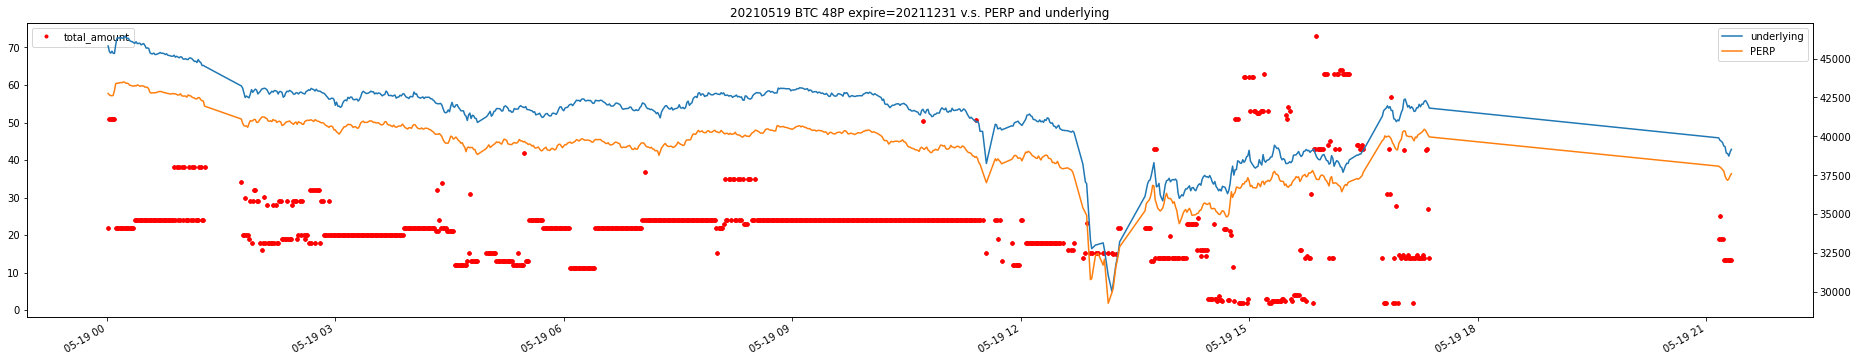

In [180]:
df_quote = ret_df_40C
df_quote['total_amount'] = df_quote['ask_amount']+df_quote['bid_amount']
optchain = optchain1Min_20210519_20211231.query('underly=="BTC-31DEC21"').query('symbol==@symbol')

df_quote_ext = df_quote.set_index('timestamp_dt').reindex(optchain.index, method='ffill').join(optchain, lsuffix='_left', rsuffix='_right')
df_quote_ext2 = df_quote_ext.join(df_perp_1min)
df2plot = df_quote_ext2[['total_amount','s','mid']]


fig, ax1 = plt.subplots(1,1, figsize=(8*4,6))

df2plot[['total_amount']].plot(ax=ax1,  linestyle='None', marker = '.', color=['r'])
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
df2plot[['s','mid']].plot(ax=ax2,)
ax2.legend(['underlying','PERP'], loc="upper right")


plt.title('20210519 BTC {} expire=20211231 v.s. PERP and underlying'.format(df_quote_str))
plt.show()

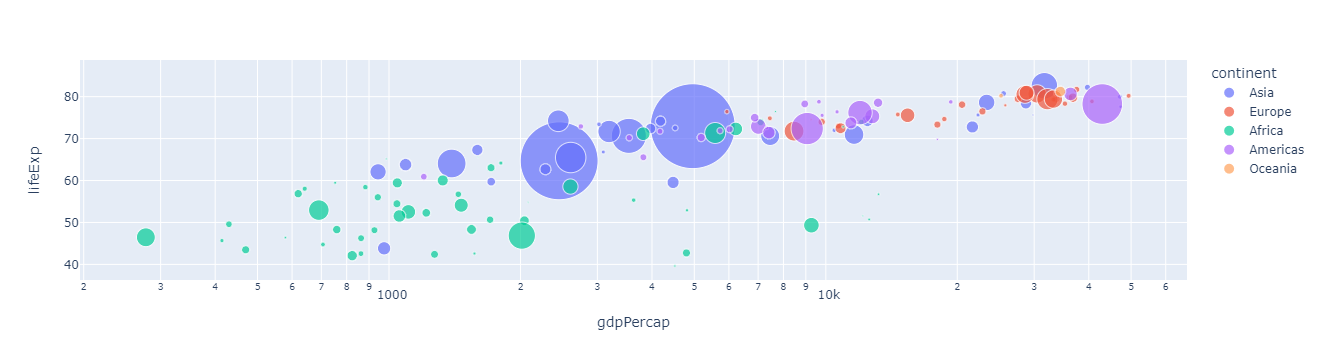

In [169]:
import plotly.express as px
df = px.data.gapminder()
fig = px.scatter(df.query("year==2007"), x="gdpPercap", y="lifeExp", size="pop", color="continent",
           hover_name="country", log_x=True, size_max=60)
fig.show()

In [184]:
df2plot = df2plot.reset_index()

In [182]:
df2plot['strike'] = 40000
df2plot['strike2'] = 40000

In [ ]:
df2plot

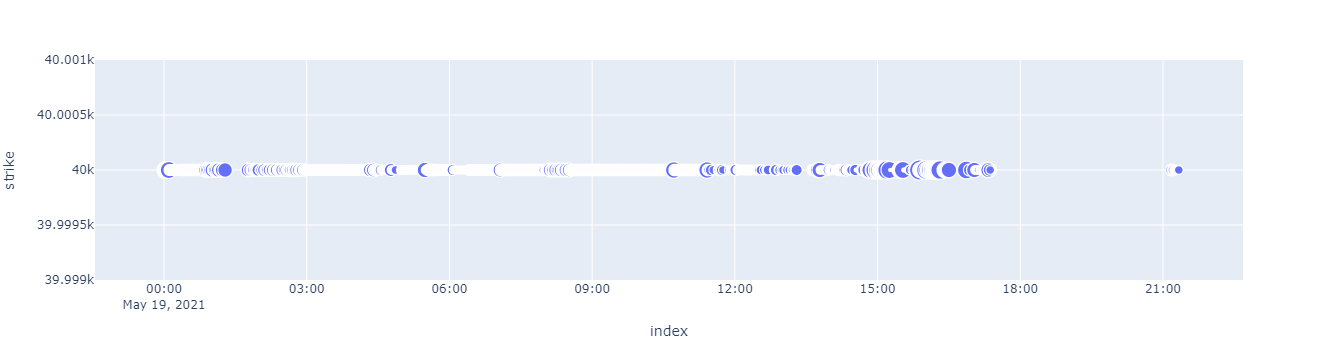

In [185]:
fig = px.scatter(df2plot, x="index", y="strike", size="total_amount",  hover_name="mid")
#fig = px.scatter(df2plot, x="index", y="strike", size="total_amount",  hover_name="mid")
fig.show()

In [201]:
ret_df_40C_reduced = ret_df_40C[['ask_amount','ask_price','bid_price','bid_amount','timestamp_dt']]

In [195]:
ret_df_40C_reduced['dt'] =  pd.to_datetime(ret_df_40C_reduced['timestamp_dt'], format='%Y')

In [ ]:
## resample time
## catagoricaize columns 
ret_df_40C_reduced['dt'].resample('3T')

In [203]:
df_quote = ret_df_40C_reduced.copy()
optchain = optchain1Min_20210519_20211231.query('underly=="BTC-31DEC21"').query('symbol==@symbol')

df_quote_ext = df_quote.set_index('timestamp_dt').reindex(optchain.index, method='ffill').join(optchain, lsuffix='_left', rsuffix='_right')

df_quote_ext2 = df_quote_ext.join(df_perp_1min)

In [205]:
df_quote_ext2.head(2)

,ask_amount,ask_price,bid_price,bid_amount,symbol,tm,aiv,ap,av,biv,...,oint,rho,strike,theta,ty,underly,s,vega,tau,mid
2021-05-19 00:01:00,11.0,0.397,0.3505,11.0,BTC-31DEC21-48000-P,2021-05-19,1.0884,0.364,12.0,0.9667,...,495.9,-201.30304,48000.0,-30.40465,-1,BTC-31DEC21,45812.83,135.81238,0.62009,42759.329932
2021-05-19 00:01:00,11.0,0.397,0.3505,11.0,BTC-31DEC21-48000-P,2021-05-19,1.0884,0.364,12.0,0.9667,...,495.9,-201.30304,48000.0,-30.40465,-1,BTC-31DEC21,45812.83,135.81238,0.62009,42759.329932


In [231]:
df2plot = df_quote_ext2[['ask_amount','ask_price','bid_price','bid_amount','tm','strike','s','mid']]

In [232]:
df2plot = df2plot[~df2plot.duplicated()]

In [233]:
df2plot.head()

,ask_amount,ask_price,bid_price,bid_amount,tm,strike,s,mid
2021-05-19 00:01:00,11.0,0.397,0.3505,11.0,2021-05-19 00:00:00,48000.0,45812.83,42759.329932
2021-05-19 00:02:00,11.0,0.397,0.3500,40.0,2021-05-19 00:01:00,48000.0,45453.92,42666.085388
2021-05-19 00:03:00,11.0,0.397,0.3500,40.0,2021-05-19 00:02:00,48000.0,45350.60,42624.524693
2021-05-19 00:04:00,11.0,0.397,0.3500,40.0,2021-05-19 00:03:00,48000.0,45475.62,42613.393516
2021-05-19 00:05:00,11.0,0.397,0.3500,40.0,2021-05-19 00:04:00,48000.0,45343.79,42633.196623


In [238]:
df2plot_ask = df2plot[['ask_amount','ask_price','tm','strike','s','mid']]
df2plot_ask['type'] = 'ask'
df2plot_ask.columns = ['amount','price','tm','strike','s','mid','type']

df2plot_bid = df2plot[['bid_amount','bid_price','tm','strike','s','mid']]
df2plot_bid['type'] = 'bid'
df2plot_bid.columns = ['amount','price','tm','strike','s','mid','type']


In [239]:
df2plot_new = df2plot_ask.append(df2plot_bid).reset_index()

In [240]:
df2plot_new[~df2plot_new.duplicated()]

,index,amount,price,tm,strike,s,mid,type
0,2021-05-19 00:01:00,11.0,0.397,2021-05-19 00:00:00,48000.0,45812.83,42759.329932,ask
1,2021-05-19 00:02:00,11.0,0.397,2021-05-19 00:01:00,48000.0,45453.92,42666.085388,ask
2,2021-05-19 00:03:00,11.0,0.397,2021-05-19 00:02:00,48000.0,45350.60,42624.524693,ask
3,2021-05-19 00:04:00,11.0,0.397,2021-05-19 00:03:00,48000.0,45475.62,42613.393516,ask
4,2021-05-19 00:05:00,11.0,0.397,2021-05-19 00:04:00,48000.0,45343.79,42633.196623,ask
...,...,...,...,...,...,...,...,...
1859,2021-05-19 21:16:00,0.4,0.300,2021-05-19 21:15:00,48000.0,38928.31,37264.584203,bid
1860,2021-05-19 21:17:00,0.4,0.300,2021-05-19 21:16:00,48000.0,38896.49,37173.428913,bid
1861,2021-05-19 21:18:00,0.4,0.300,2021-05-19 21:17:00,48000.0,38730.83,37270.547811,bid
1862,2021-05-19 21:19:00,0.4,0.300,2021-05-19 21:18:00,48000.0,38995.81,37459.721912,bid


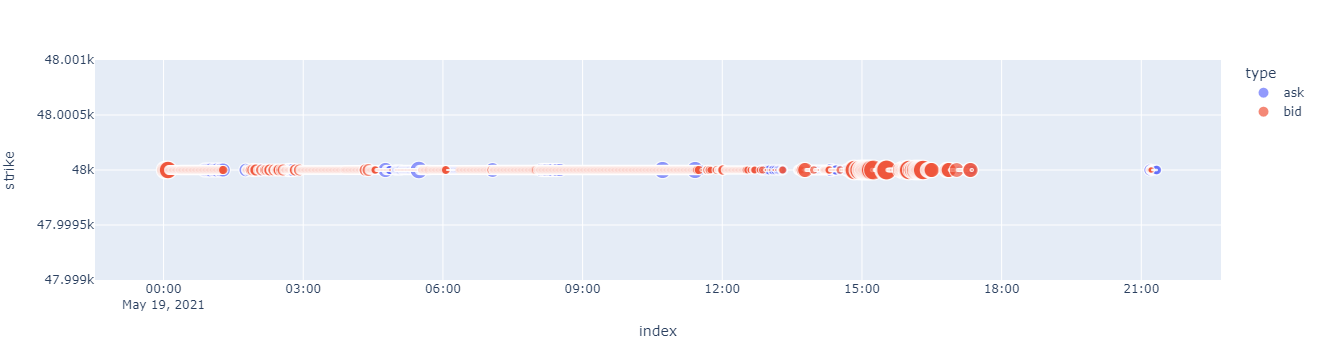

In [249]:
from plotly.subplots import make_subplots
subfig = make_subplots(specs=[[{"secondary_y": True}]])
fig = px.scatter(df2plot_new, x="index", y="strike", size="amount",  hover_name="price", color="type")

fig.show()

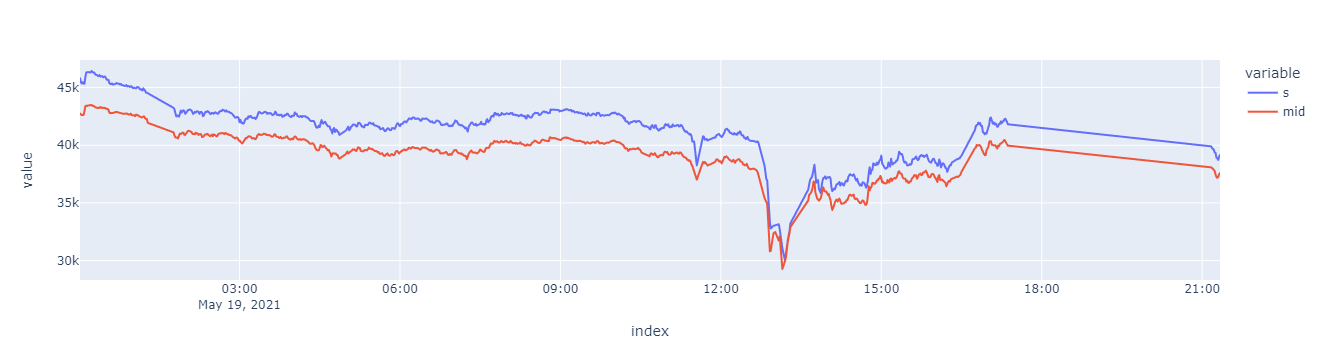

In [248]:
fig2 = px.line(df2plot_new.query('type=="ask"'), x="index", y=['s','mid'])
fig2.show()

In [250]:
import plotly.graph_objects as go

fig3 = go.Figure(data=fig.data + fig2.data)

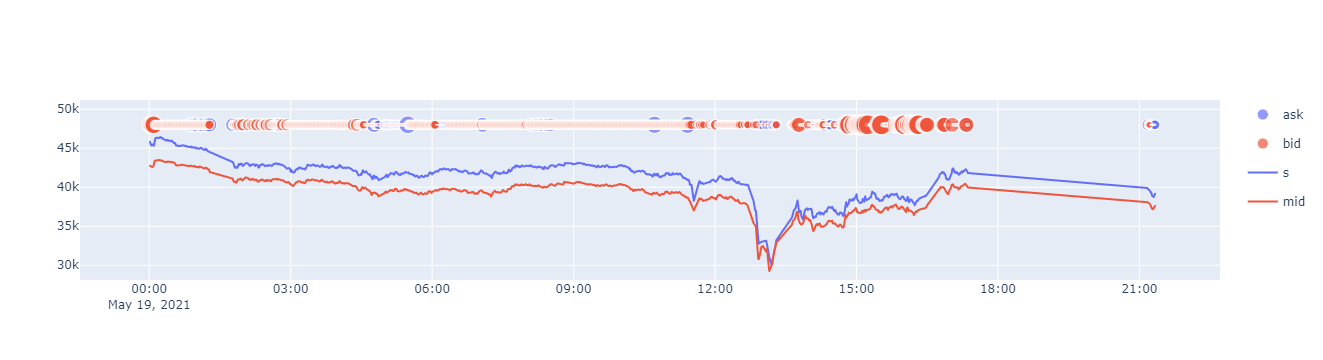

In [251]:
fig3.show()

In [253]:
fig3.write_html("file.html")